In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Custom Data Generator Loop (NAICS hierarchy)
Loop through fill rates with a custom generator, to see how the performance varies.

NAICS + Hiearchy groups, and data with no missing values

*This script takes about 10 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib.ticker as ticker

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model, sbnn_plot
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

In [8]:
sbnn_plot.plot_defaults()

## Input Data

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [12]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [13]:
# NAICS feature
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [14]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [15]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [16]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [17]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


In [18]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

## Loop for different fits

In [19]:
def gen_fit_loop(rate = 0.1):
    this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)
    generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = rate,
                               injection_value = 1)
    callback = keras.callbacks.EarlyStopping(patience=3)
    
    # Fit - vary rate
    this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                             callbacks=[callback])
    this_history_df = sbnn_model.process_history(this_history)
    this_history_df['rate'] = rate
    
    # Predictions then metrics
    this_predict = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])
    this_predict_df = pd.DataFrame(this_predict, index=X.index) \
        .set_axis(['predict_prob'], axis=1) \
        .reset_index() \
        .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
               on='LoanNr_ChkDgt')
    
    # Threshold tune
    this_pred_train = this_predict_df[this_predict_df['dset'] == 'train']
    thresh_tune_data = sbnn_metrics.get_f1_frame(this_pred_train['target'], 
                                        this_pred_train['predict_prob'])
    thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
    best_thresh = thresh_tune_data['thresh'].iloc[0]
    this_predict_df['predict_bin'] = sbnn_metrics.get_binary_predictions(this_predict_df['predict_prob'], 
                                                                            best_thresh)
    
    this_metrics_dset = this_predict_df.groupby('dset') \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics_test = this_predict_df[this_predict_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics = pd.concat([this_metrics_dset, this_metrics_test])
    this_metrics['rate'] = rate
    this_metrics['thresh'] = best_thresh
    
    return this_history_df, this_metrics


## Run Loop

In [20]:
rate_vals = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]

In [21]:
history = pd.DataFrame()
metrics = pd.DataFrame()

In [22]:
%%capture
for r in rate_vals:
    this_hist, this_met = gen_fit_loop(r)
    history = pd.concat([history, this_hist])
    metrics = pd.concat([metrics, this_met])

2024-05-23 22:18:32.201141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-23 22:18:32.201166: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-23 22:18:32.201180: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-23 22:18:32.201222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 22:18:32.201239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-23 22:18:33.021237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-23 22:21:57.526040: I t

In [23]:
history['epoch'] = history.groupby('rate').cumcount()
history.to_csv(Path(setup.temp_path).joinpath('13_REPORT_loop_history.csv'))

In [24]:
metrics.to_csv(Path(setup.temp_path).joinpath('13_REPORT_loop_metrics.csv'))

In [25]:
metrics[metrics['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
0,test,0.643145,0.447451,0.326414,0.711151,0.379227,0.726110,0.0,0.0000,0.24
0,test,0.648639,0.447116,0.328621,0.699253,0.379886,0.726236,0.0,0.0010,0.20
0,test,0.675544,0.448151,0.342399,0.648416,0.382602,0.727735,0.0,0.0050,0.22
0,test,0.652930,0.448271,0.331064,0.693948,0.381404,0.727617,0.0,0.0100,0.24
0,test,0.646682,0.447050,0.327738,0.702962,0.379107,0.726206,0.0,0.0500,0.22
0,test,0.648137,0.445119,0.327489,0.694618,0.376866,0.724849,0.0,0.1000,0.20
0,test,0.670846,0.446649,0.339176,0.653824,0.380176,0.726497,0.0,0.3000,0.22
0,test,0.648744,0.446460,0.328368,0.697193,0.377851,0.725748,0.0,0.5000,0.22
0,test,0.649298,0.444245,0.327602,0.689879,0.371755,0.722066,0.0,0.7000,0.20
0,test,0.661113,0.438624,0.330572,0.651610,0.369235,0.717857,0.0,0.8000,0.20


In [26]:
metrics[metrics['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
1,test,0.550956,0.431366,0.288484,0.854674,0.372315,0.731885,1.0,0.0000,0.24
1,test,0.625733,0.445195,0.315926,0.753513,0.369219,0.729169,1.0,0.0010,0.20
1,test,0.667565,0.445868,0.333825,0.671118,0.381188,0.732639,1.0,0.0050,0.22
1,test,0.654259,0.449863,0.329375,0.709348,0.378829,0.736216,1.0,0.0100,0.24
1,test,0.638587,0.451739,0.323740,0.747141,0.384559,0.738168,1.0,0.0500,0.22
1,test,0.661286,0.450614,0.332916,0.697041,0.381392,0.736424,1.0,0.1000,0.20
1,test,0.678889,0.455251,0.343884,0.673300,0.386877,0.741415,1.0,0.3000,0.22
1,test,0.668713,0.454519,0.338250,0.692590,0.384323,0.738900,1.0,0.5000,0.22
1,test,0.673810,0.454109,0.340671,0.680806,0.383726,0.736755,1.0,0.7000,0.20
1,test,0.682681,0.450959,0.344143,0.653923,0.381304,0.737660,1.0,0.8000,0.20


## Plots

In [27]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

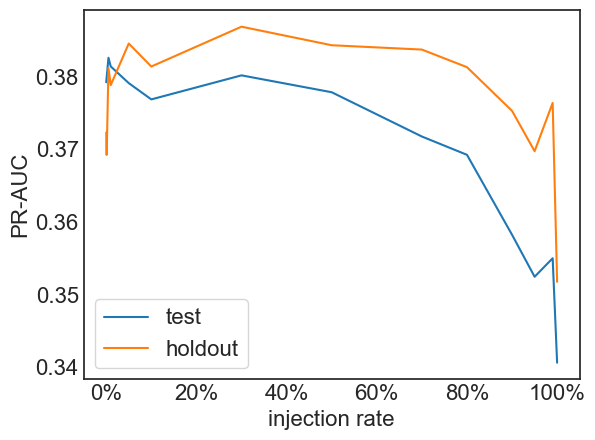

In [28]:
fig = sbnn_plot.plot_metric_dependence(metrics, xformatter = ticker.PercentFormatter(1),
                                      ylabel='PR-AUC',
                            xlabel='injection rate')
fig.savefig(Path(setup.temp_path).joinpath('13_PLOT_average_precision.png'),
            bbox_inches='tight')

##### History

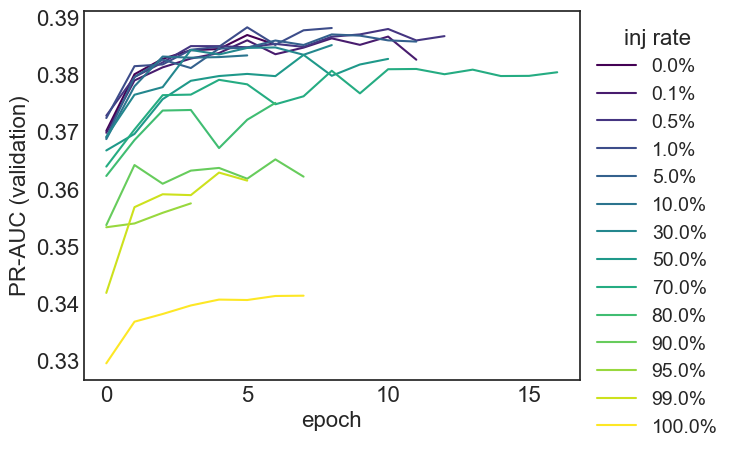

In [29]:
fig = sbnn_plot.plot_history_group(history,
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'PR-AUC (validation)',
                                  leg_title='inj rate')
fig.savefig(Path(setup.temp_path).joinpath('13_PLOT_hostory_val_auc.png'),
            bbox_inches='tight')

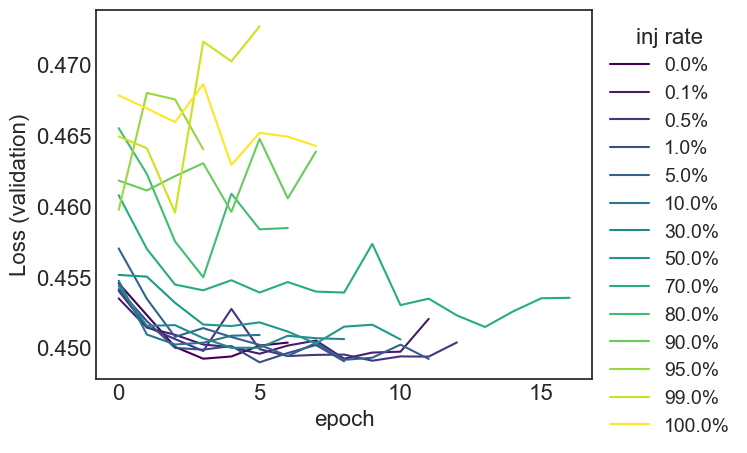

In [30]:
fig = sbnn_plot.plot_history_group(history, 'val_loss',
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'Loss (validation)',
                                  leg_title='inj rate')
fig.savefig(Path(setup.temp_path).joinpath('13_PLOT_hostory_val_loss.png'),
            bbox_inches='tight')

## Max epochs

In [31]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

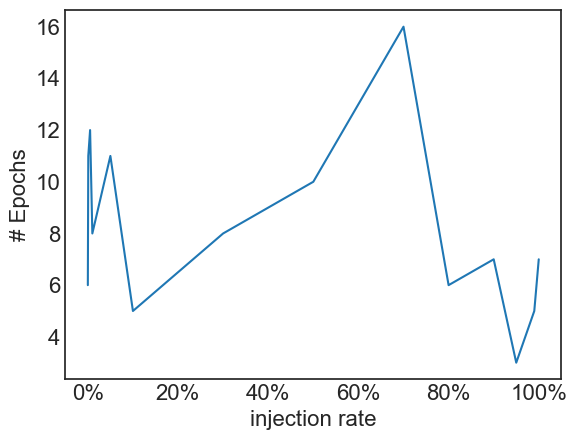

In [32]:
fig = sbnn_plot.plot_epoch_agg(history,
                               xformatter = ticker.PercentFormatter(1),
                               ylabel='# Epochs',
                               xlabel='injection rate')
fig.savefig(Path(setup.temp_path).joinpath('13_PLOT_hostory_epochs.png'),
            bbox_inches='tight')